In [1]:
from pdf2image import convert_from_path
from pdf2image.exceptions import (
    PDFInfoNotInstalledError,
    PDFPageCountError,
    PDFSyntaxError
)
from pdfminer.high_level import extract_text
import base64
import io
import os
import concurrent.futures
from tqdm import tqdm
from openai import OpenAI
import re
import pandas as pd 
from sklearn.metrics.pairwise import cosine_similarity
import json
import numpy as np
from rich import print
from ast import literal_eval

In [2]:
def convert_doc_to_images(path):
    images = convert_from_path(path)
    return images

def extract_text_from_doc(path):
    text = extract_text(path)
    return text

In [3]:
file_path = "instructionset.pdf"

images = convert_doc_to_images(file_path)

In [4]:

text = extract_text_from_doc(file_path)

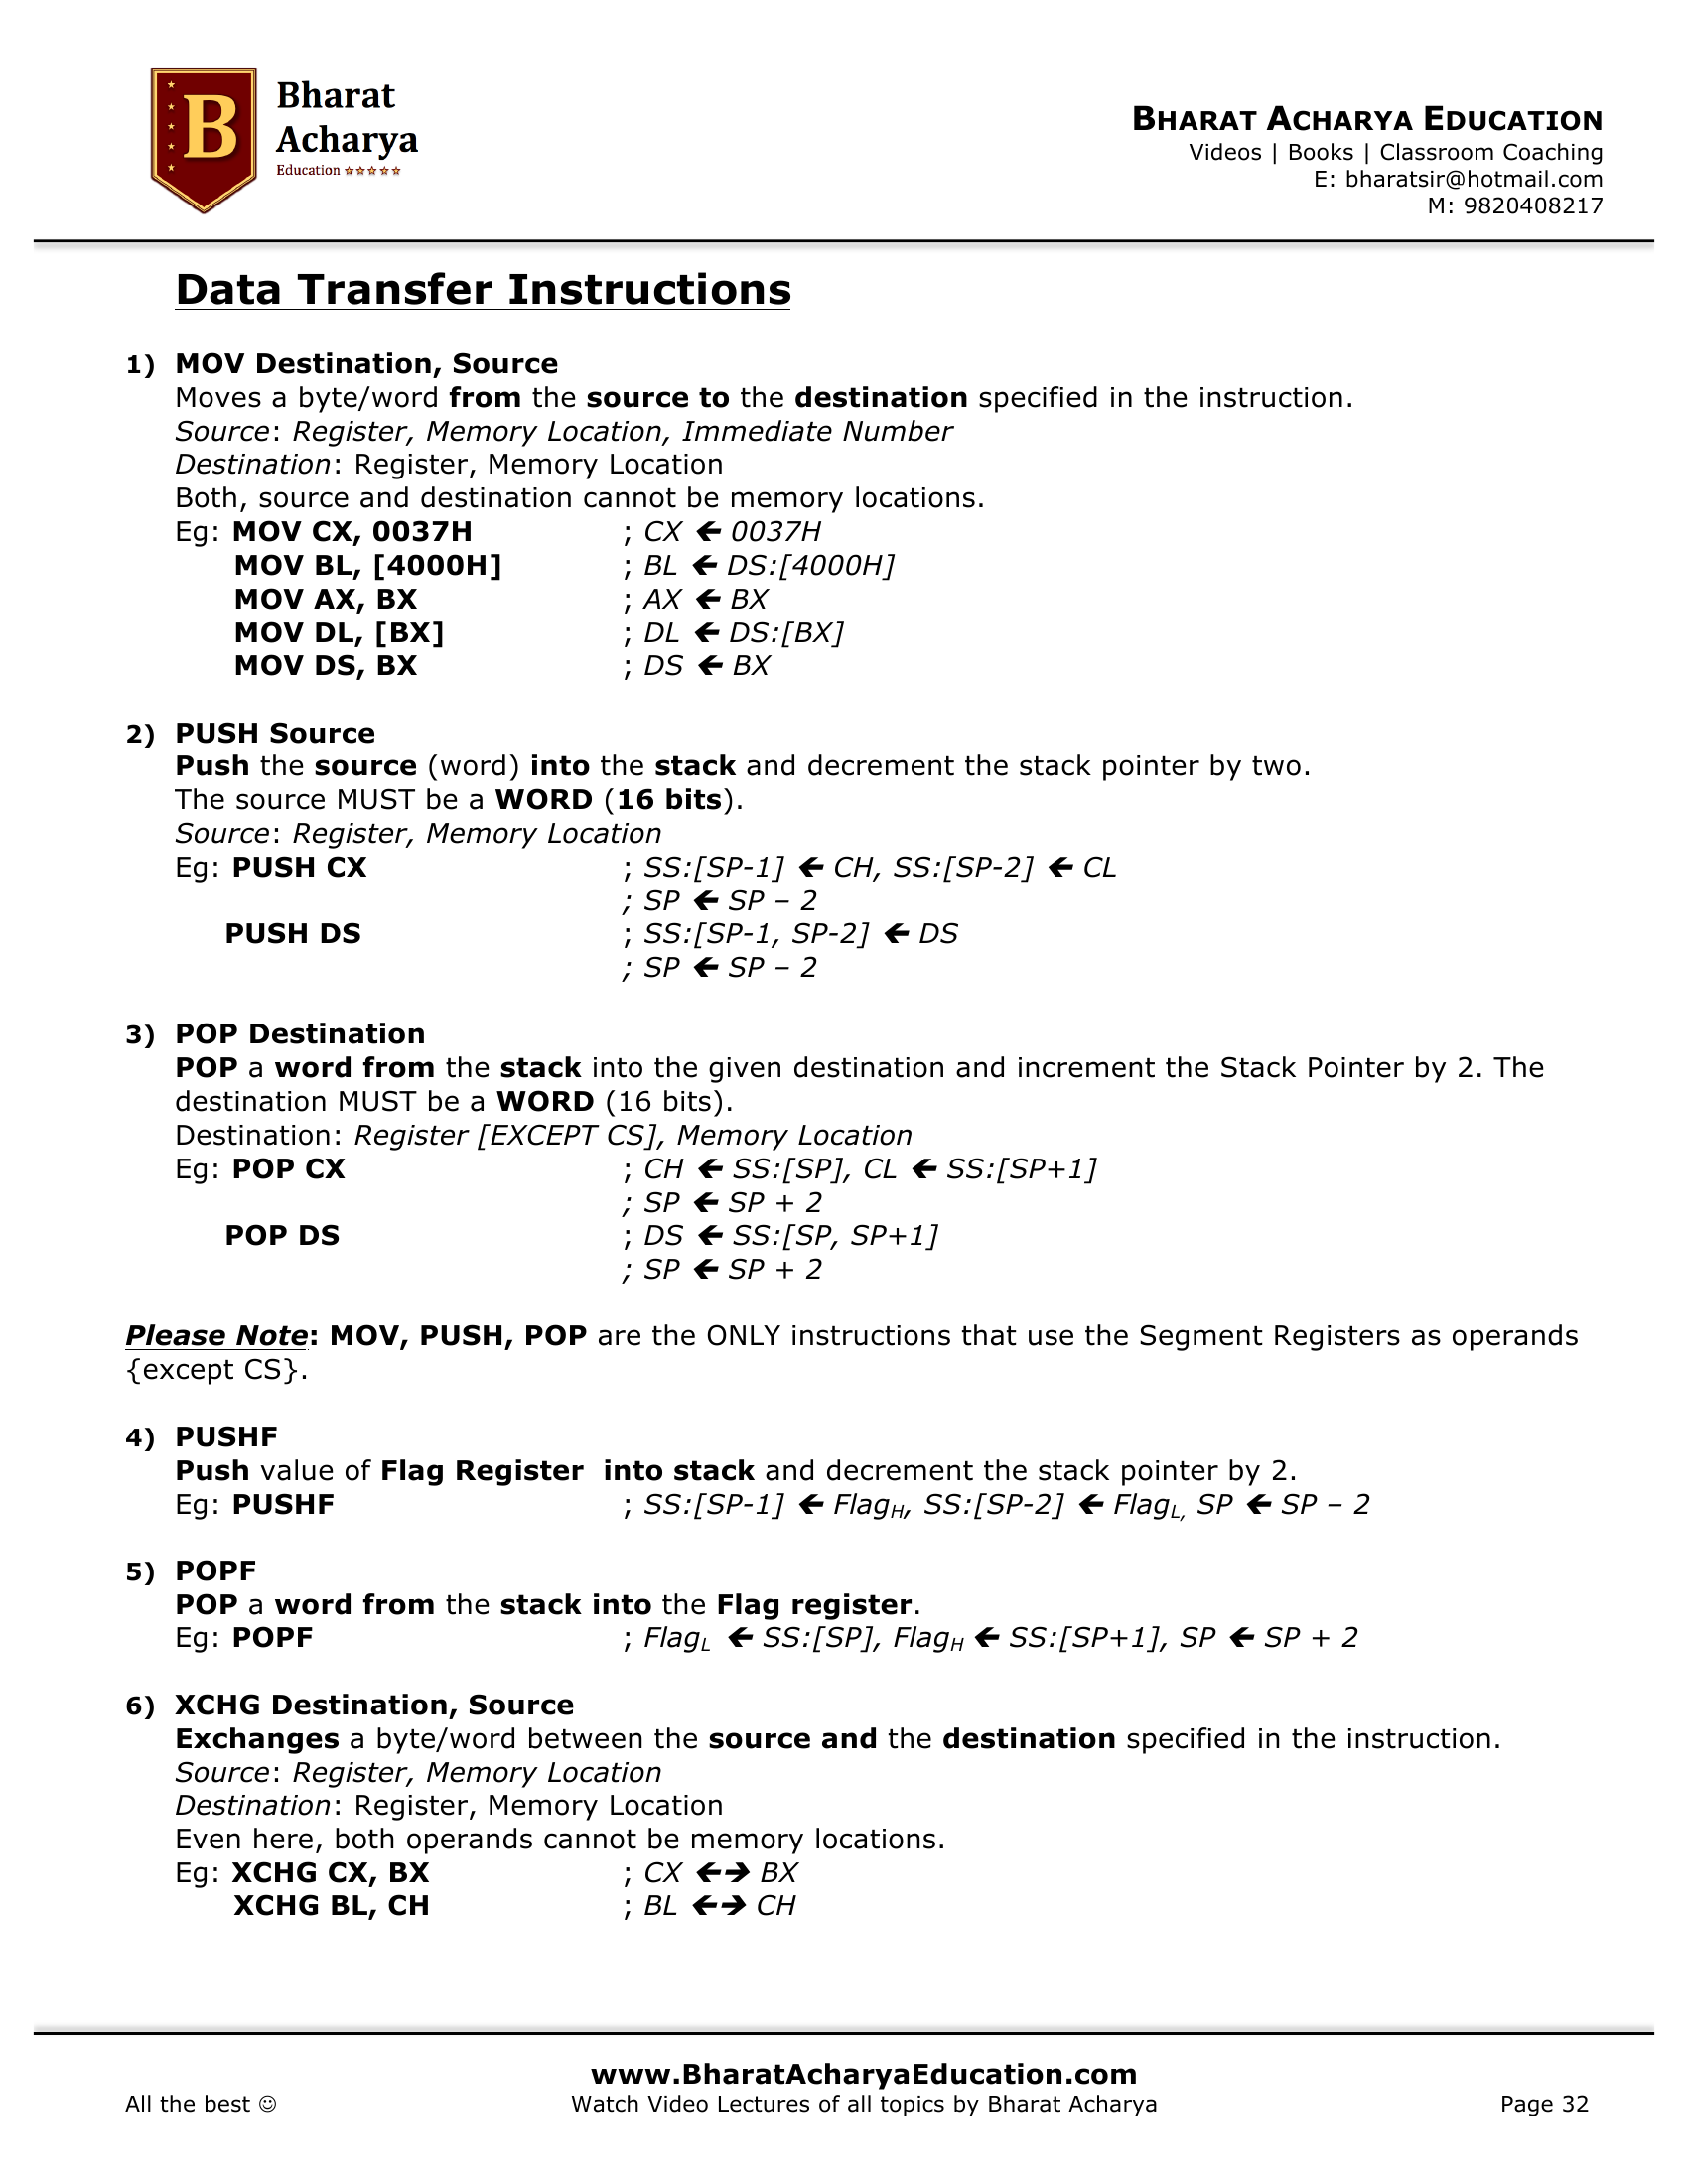

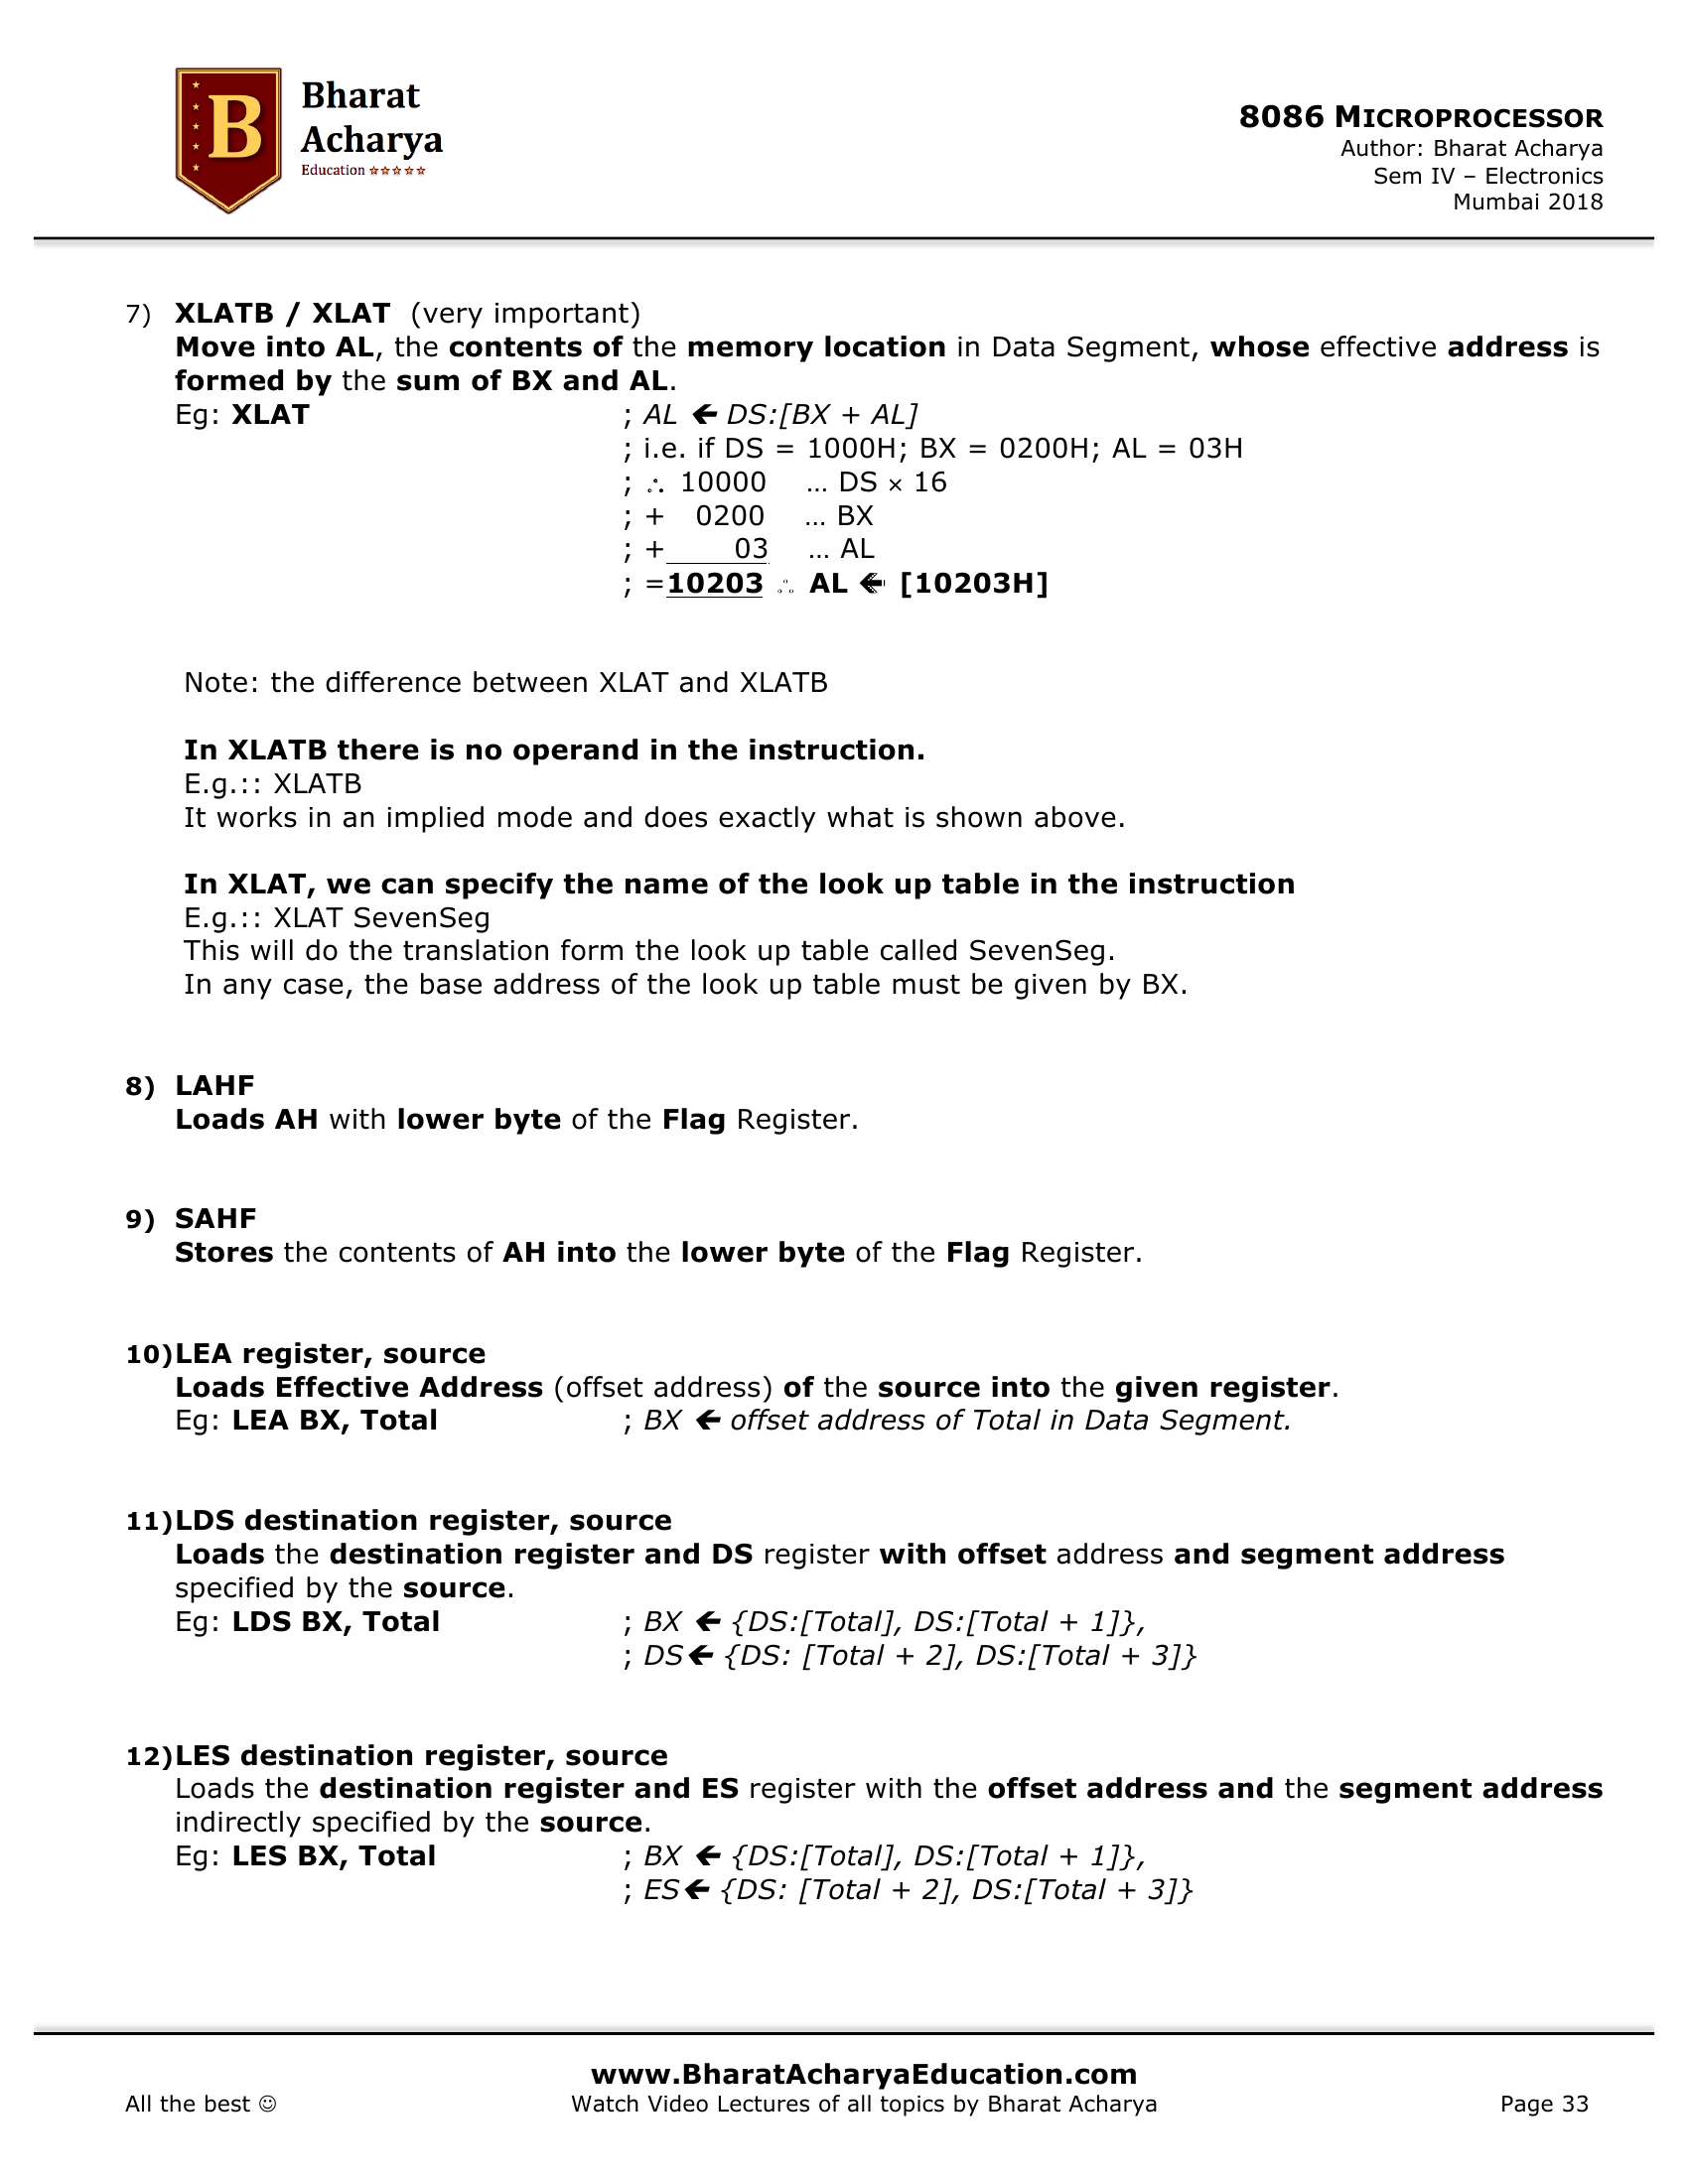

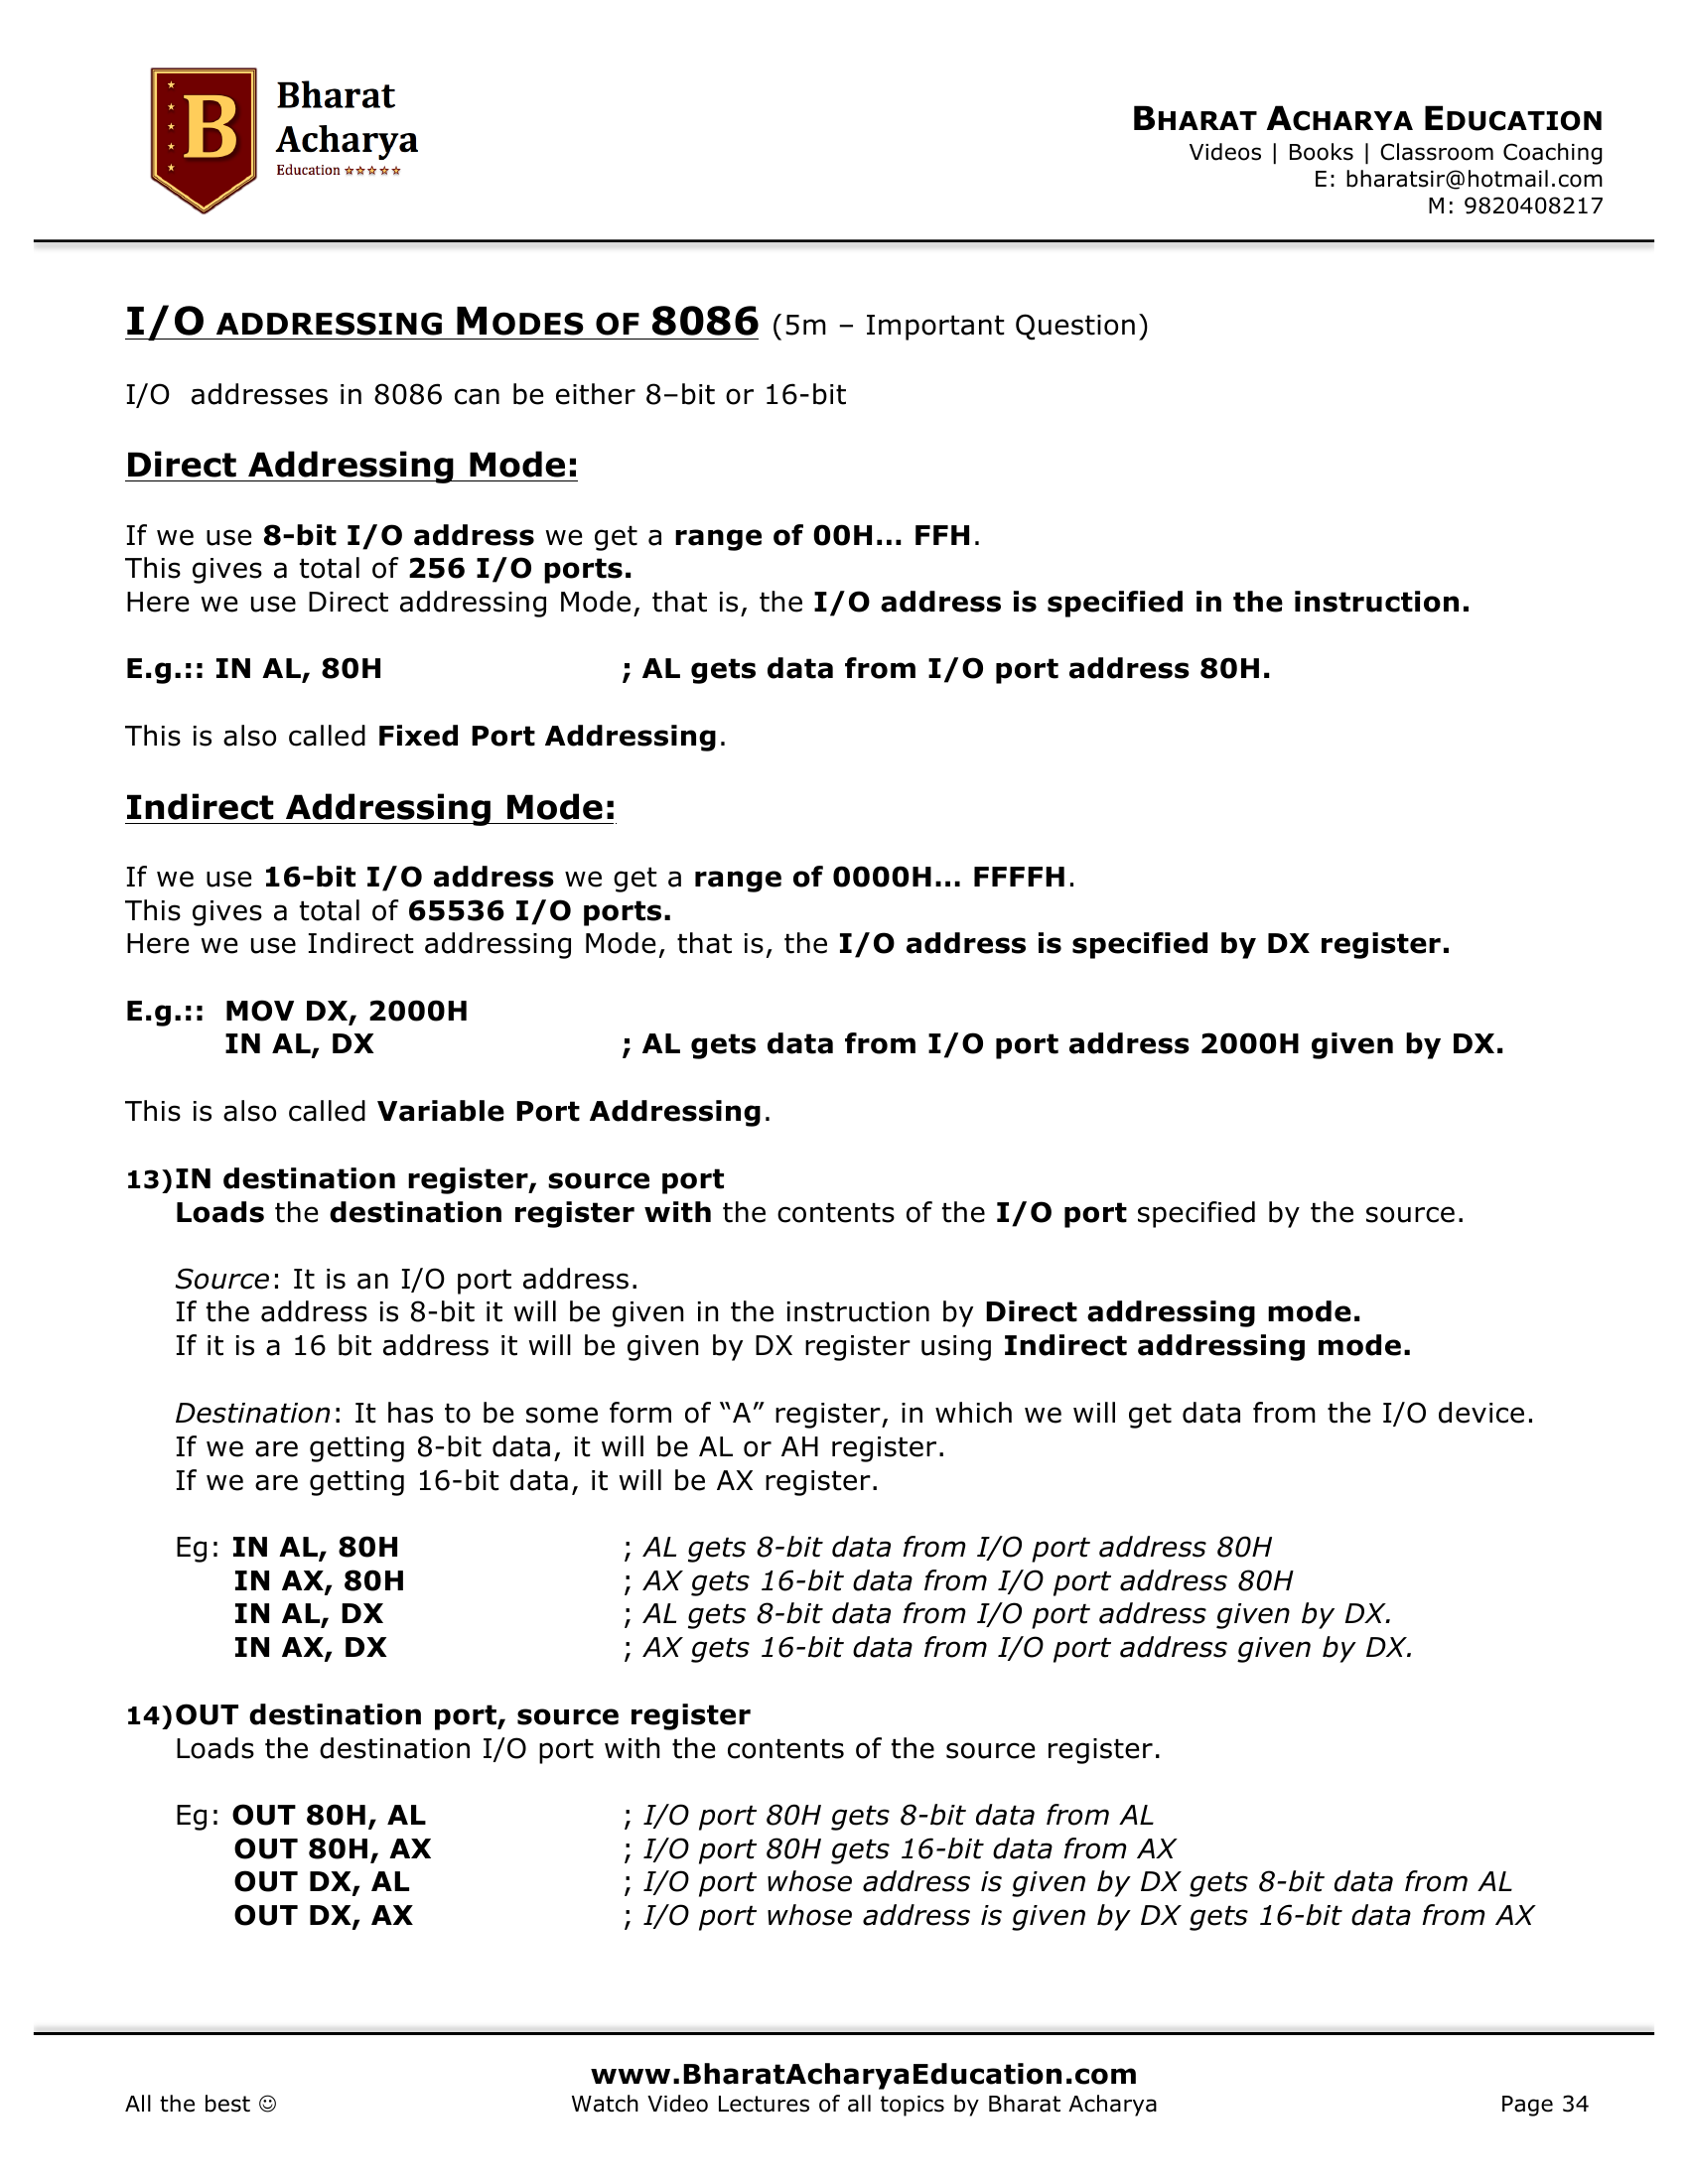

In [5]:

for img in images:
    display(img)

In [6]:
import os
from dotenv import load_dotenv
load_dotenv()
api_key = os.getenv("OPENAI_API_KEY")
client = OpenAI(api_key=api_key)


In [7]:
# Converting images to base64 encoded images in a data URI format to use with the ChatCompletions API
def get_img_uri(img):
    png_buffer = io.BytesIO()
    img.save(png_buffer, format="PNG")
    png_buffer.seek(0)

    base64_png = base64.b64encode(png_buffer.read()).decode('utf-8')

    data_uri = f"data:image/png;base64,{base64_png}"
    return data_uri

In [8]:
system_prompt = '''
Task: Extract structured content from the image with special focus on key elements

1. Diagrams, Flowcharts, or Arrow/Line-heavy Visuals:
   - **Identify and capture the flow of logic** between labeled elements connected by **arrows** or **lines**.
   - Represent the connections clearly with **arrow symbols (→)** to show the **direction** of the flow between the connected elements or steps.
   - **Lines** connecting items should be represented by either arrow symbols (→) or "Line" if no arrow is present.
   - Example format:  
     A → B → C → D  
     If there are intermediate steps:  
     Step 1 → Step 2 → Step 3 → Final Result  
     If a line connects nodes without an arrow, indicate as:  
     A --- B --- C

2. Labeled Boxes, Nodes, or Processes:
   - Extract **text inside labeled nodes or boxes** and **identify** how they are connected by arrows or lines.
   - Follow the flow as indicated, ensuring the connection between nodes is preserved. 
   - Ensure that the nodes or boxes represent **steps or processes** in the sequence.

3. Tabular Data:
   - For any **table** or **row-based structure**:
     - Separate the data for each row using **“-”** between column values.
     - Example format:  
       Row 1: Column 1 data - Column 2 data - Column 3 data  
       Row 2: Column 1 data - Column 2 data - Column 3 data  
     - Ensure the **alignment of data** with respective rows and columns.

4. Textual Content:
   - Extract only **key phrases**, headers, or **important terms** from the image.
   - Avoid filler text or lengthy explanations unless they are critical for context.

5. Metadata Extraction:
   - Extract **Page Number** and **Chapter Title** or **Section Name** if available (e.g., “Chapter 3: Introduction to Diagrams”).

---

**Output format**:

Page: {Page Number}  
Chapter: {Chapter Title or Section Name}

{If applicable: Title or Header}

Flow:  
A → B → C → D  
or  
A --- B --- C (if lines connect them without arrows)

Steps:  
- Step 1: {Label inside first node}  
- Step 2: {Label inside second node}  
- Step 3: {Label inside third node}  
- Output: {Final result or end point}

Tabular Data:  
Row 1: {Column 1 data} - {Column 2 data} - {Column 3 data}  
Row 2: {Column 1 data} - {Column 2 data} - {Column 3 data}  
...

Text:  
- {Relevant key phrase 1}  
- {Relevant key phrase 2}  
- {Relevant key phrase 3}



'''

def analyze_image(data_uri):
    response = client.chat.completions.create(
        model="gpt-4.1",
        messages=[
            {"role": "system", "content": system_prompt},
            {
                "role": "user",
                "content": [
                    {
                    "type": "image_url",
                    "image_url": {
                        "url": f"{data_uri}"
                    }
                    }
                ]
                },
        ],
        max_tokens=2000,
        temperature=0.1,
        top_p=0.1
    )
    return response.choices[0].message.content

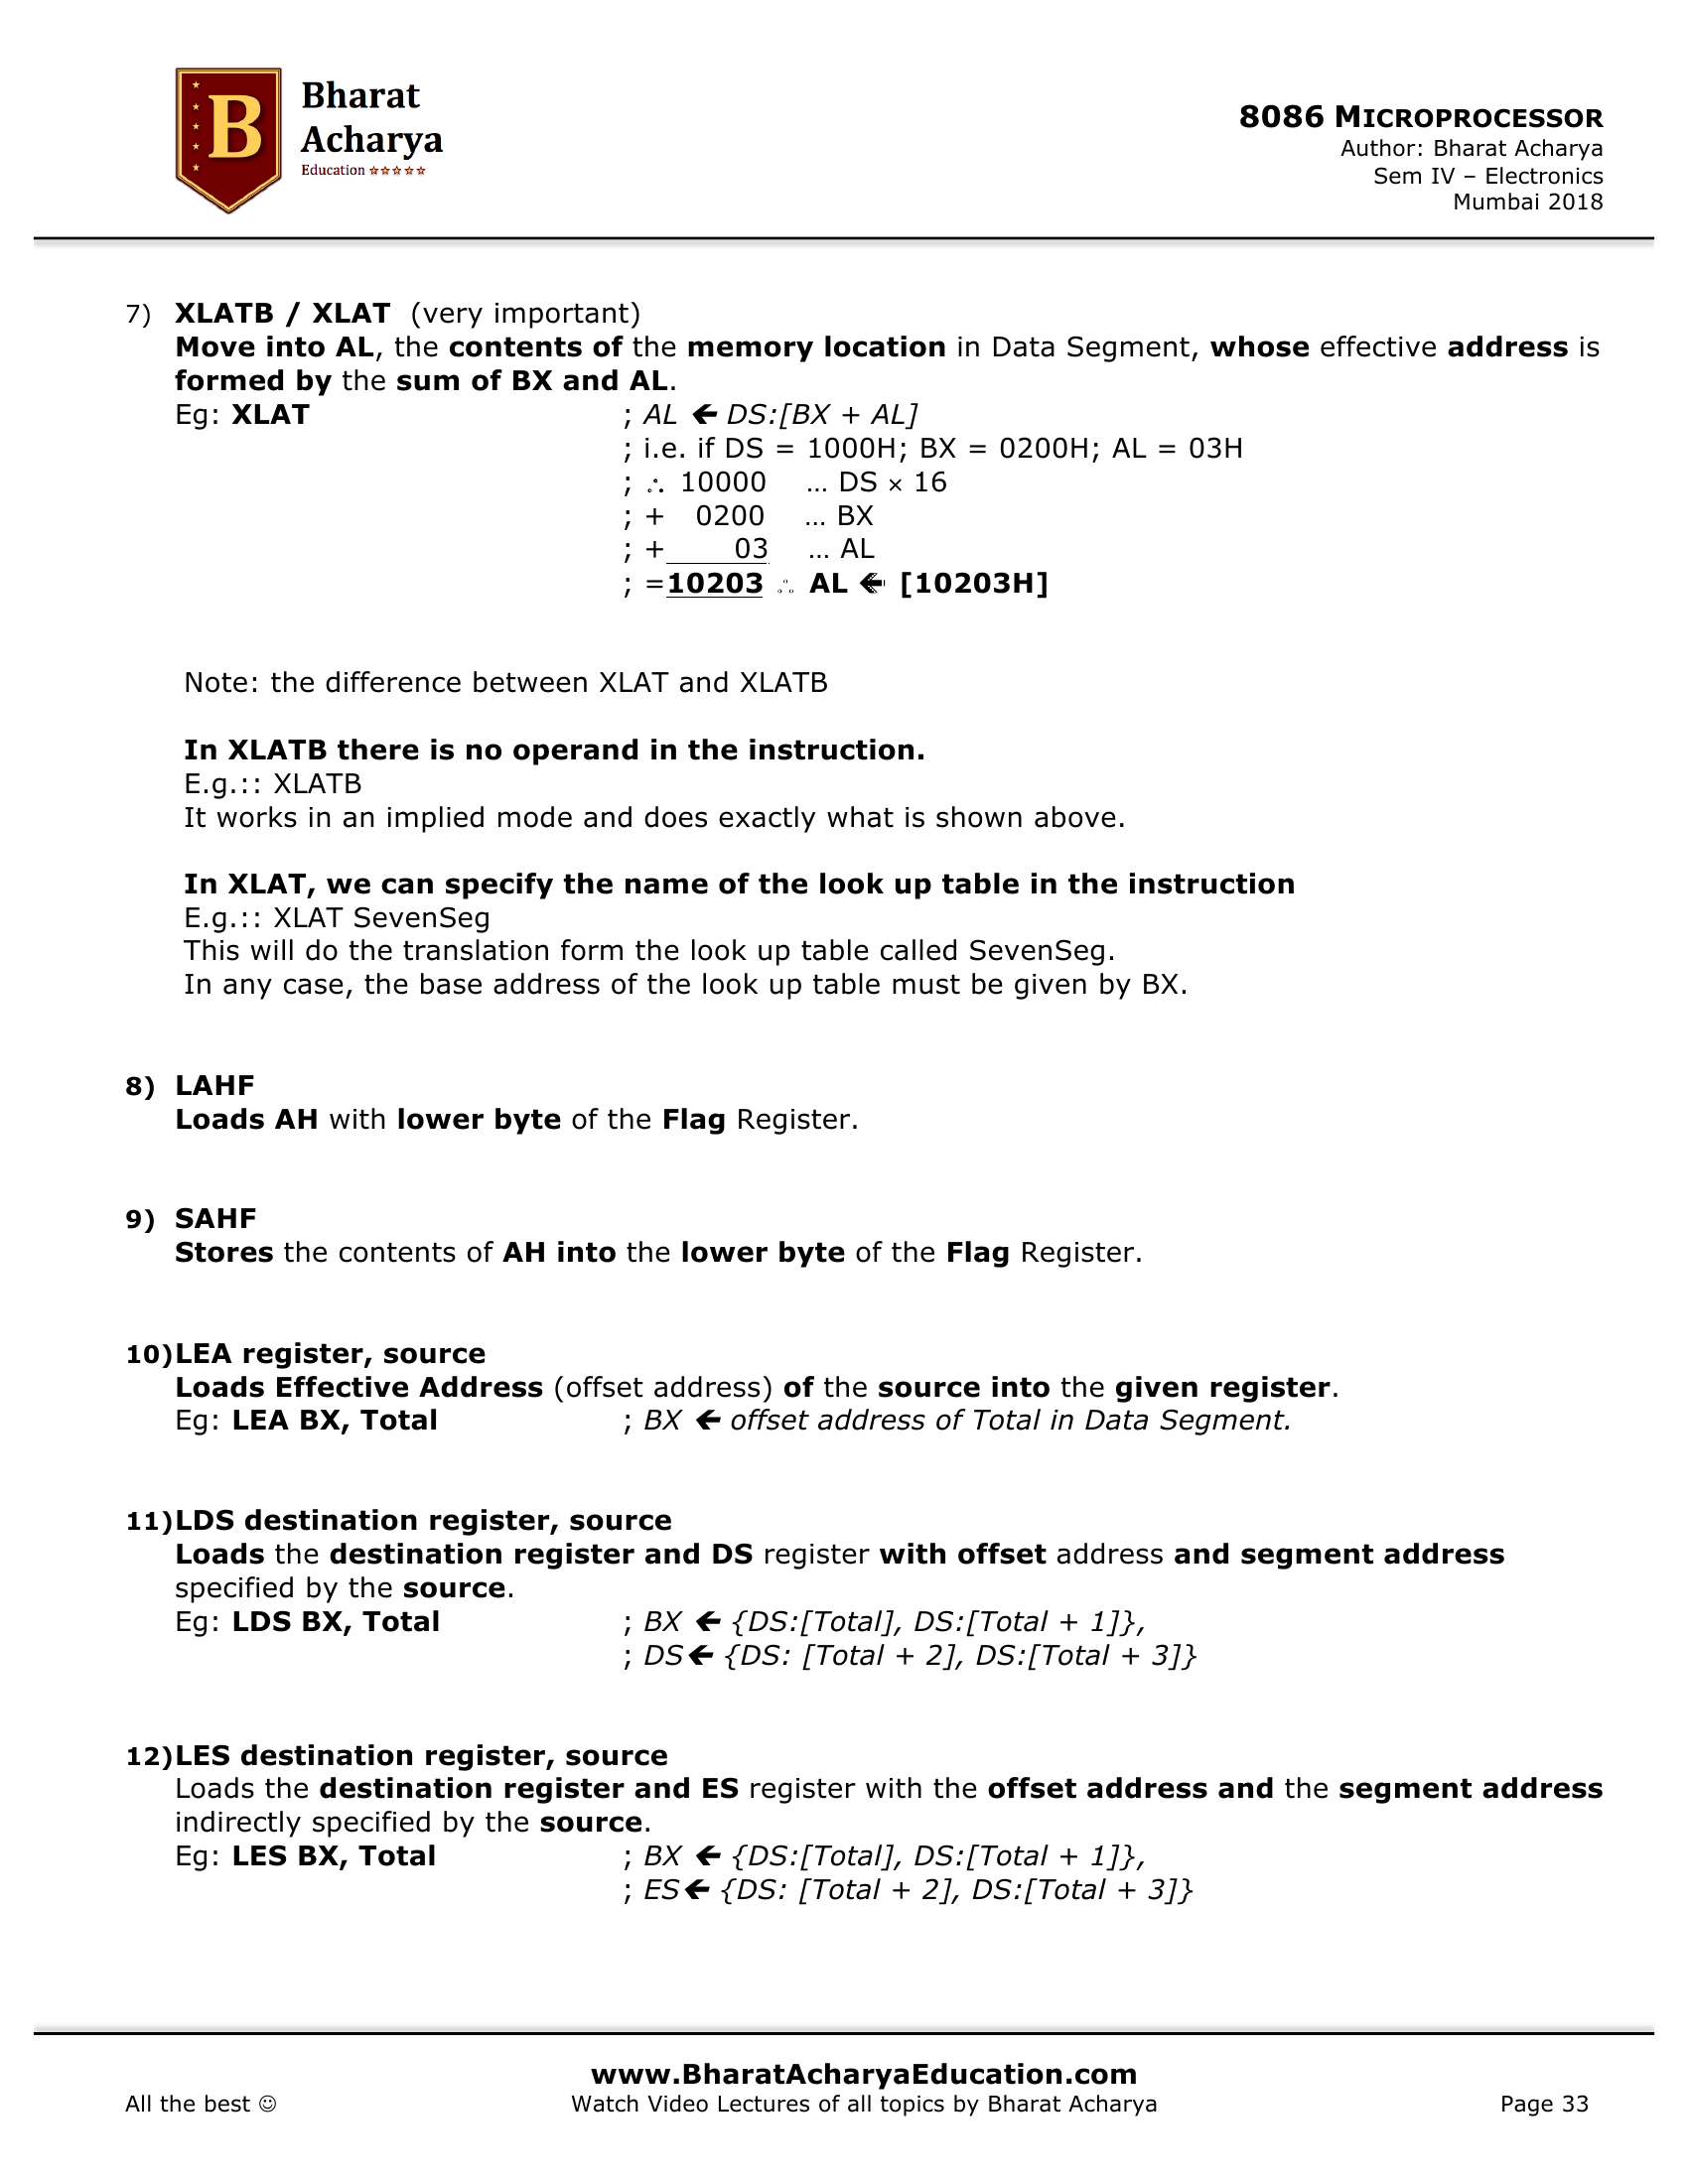

In [9]:
img = images[1]
display(img)
data_uri = get_img_uri(img)

In [10]:
res = analyze_image(data_uri)
print(res)

Page: 33  
Chapter: 8086 Microprocessor

Key Instructions and Concepts:

**XLATB / XLAT**  
- Move into AL, the contents of the memory location in Data Segment, whose effective address is formed by the sum 
of BX and AL.
- Example:  
  AL ⇐ DS:[BX + AL]  
  If DS = 1000H, BX = 0200H, AL = 03H  
  Effective address = 10000 (DS × 16) + 0200 (BX) + 03 (AL) = 10203  
  AL ⇐ [10203H]

Text:  
- Difference between XLAT and XLATB:
  - **XLATB**: No operand in the instruction, works in implied mode.
  - **XLAT**: Can specify the name of the look-up table in the instruction.

**LAHF**  
- Loads AH with lower byte of the Flag Register.

**SAHF**  
- Stores the contents of AH into the lower byte of the Flag Register.

**LEA register, source**  
- Loads Effective Address (offset address) of the source into the given register.
- Example: LEA BX, Total → BX ⇐ offset address of Total in Data Segment.

**LDS destination register, source**  
- Loads the destination register and DS register with offset address and segment address specified by the source.
- Example:  
  BX ⇐ {DS:[Total], DS:[Total + 1]}  
  DS ⇐ {DS:[Total + 2], DS:[Total + 3]}

**LES destination register, source**  
- Loads the destination register and ES register with the offset address and the segment address indirectly 
specified by the source.
- Example:  
  BX ⇐ {DS:[Total], DS:[Total + 1]}  
  ES ⇐ {DS:[Total + 2], DS:[Total + 3]}

Text:  
- XLATB / XLAT (very important)
- Move into AL, the contents of the memory location in Data Segment, whose effective address is formed by the sum 
of BX and AL.
- In XLATB there is no operand in the instruction.
- In XLAT, we can specify the name of the look up table in the instruction.
- LAHF: Loads AH with lower byte of the Flag Register.
- SAHF: Stores the contents of AH into the lower byte of the Flag Register.
- LEA: Loads Effective Address (offset address) of the source into the given register.
- LDS: Loads the destination register and DS register with offset address and segment address specified by the 
source.
- LES: Loads the destination register and ES register with the offset address and the segment address indirectly 
specified by the source.